In [1]:
import sys, os
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hddm
from joblib import Parallel, delayed
from IPython import embed as shell

/Users/janwillem/anaconda2/envs/ddm/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
def fit_subject(data, quantiles):
    subj_idx = data.iloc[0]['subj_idx']
    m = hddm.HDDMStimCoding(data, stim_col='stimulus', split_param='v', drift_criterion=True, bias=True, p_outlier=0,
                            depends_on={'v':'condition', 'a':'condition', 't':'condition', 'z':'condition', 'dc':'condition', })
#     m.map(runs=5)
    m.optimize('gsquare', quantiles=quantiles, n_runs=5)
    res = pd.concat((pd.DataFrame([m.values], index=[subj_idx]), pd.DataFrame([m.bic_info], index=[subj_idx])), axis=1)
    return res

def get_params(params, subj, condition=False):
    
    # Set parameters
    try:
        a = params.iloc[subj]['a({})'.format(condition)]
    except:
        a = params.iloc[subj]['a']
    try:
        v = params.iloc[subj]['v({})'.format(condition)]
    except:
        v = params.iloc[subj]['v']
    try:
        t = params.iloc[subj]['t({})'.format(condition)]
    except:
        t = params.iloc[subj]['t']
    try:
        z = params.iloc[subj]['z({})'.format(condition)]
    except:
        try:
            z = params.iloc[subj]['z']
        except:
            z = 0.5
    try:
        dc = params.iloc[subj]['dc({})'.format(condition)]
    except:
        try:
            dc = params.iloc[subj]['dc']
        except:
            dc = 0
    try:
        sv = params.iloc[subj]['sv']
    except: 
        sv = 0
    sz = 0
    st = 0
    
    return (z, a, v, dc, t, sv, sz, st)
    
def get_choice(row):

    if row.condition == 'present':
        if row.response == 1:
            return 1
        else:
            return 0
    elif row.condition == 'absent':
        if row.response == 0:
            return 1
        else:
            return 0

def simulate_data(z, a, v, dc, t, sv, sz, st, condition, nr_trials1, nr_trials2):
    
    parameters1 = {'v':v+dc, 'a':a, 't':t, 'sv':sv, 'z':z, 'sz': sz, 'st': st}
    parameters2 = {'v':v-dc, 'a':a, 't':t, 'sv':sv, 'z':1-z, 'sz': sz, 'st': st}
    df_sim1, params_sim1 = hddm.generate.gen_rand_data(params=parameters1, size=nr_trials1, subjs=1, subj_noise=0)
    df_sim1['condition'] = 'present'
    df_sim2, params_sim2 = hddm.generate.gen_rand_data(params=parameters2, size=nr_trials2, subjs=1, subj_noise=0)
    df_sim2['condition'] = 'absent'
    df_sim = pd.concat((df_sim1, df_sim2))
    df_sim['bias_response'] = df_sim.apply(get_choice, 1)
    df_sim['correct'] = df_sim['response'].astype(int)
    df_sim['response'] = df_sim['bias_response'].astype(int)
    df_sim['stimulus'] = np.array((np.array(df_sim['response']==1) & np.array(df_sim['correct']==1)) + (np.array(df_sim['response']==0) & np.array(df_sim['correct']==0)), dtype=int)
    df_sim['condition'] = condition
    df_sim = df_sim.drop(columns=['bias_response'])
    
    return df_sim
    
def model_fit(params, data, condition=False, quantiles=[.1, .3, .5, .7, .9], dt=0.01, stimulus_coding=True, nr_trials=10000):
    
    plot_nr = 1
    nogo = False
    
    nr_rows = int(np.ceil(params.shape[0] / 4.0)) + 1
    tmax = np.percentile(data.loc[~np.isnan(data.rt),'rt'], 97.5) + 0.1
    
    if np.all(~np.isnan(data['rt'])):
        fig = plt.figure(figsize=(6,nr_rows*1.5))
    else:
        fig = plt.figure(figsize=(8,nr_rows*1.5))
    
    for subj in np.unique(data['subj_idx']):
        
        # print:
        print("plot subj {}".format(subj))
        
        # empirical data:
        if condition == None:
            data_emp_subj = data.loc[(data['subj_idx']==subj)]
        else:
            data_emp_subj = data.loc[(data['subj_idx']==subj) & (data['condition']==condition)]
        
        # simulated data:
        z, a, v, dc, t, sv, sz, st = get_params(params=params, subj=subj, condition=condition)
        nr_trials1 = nr_trials
        scaling = nr_trials1 / data_emp_subj['stimulus'].sum()
        nr_trials2 = (data_emp_subj.shape[0] - data_emp_subj['stimulus'].sum()) * scaling
        data_sim_subj = simulate_data(z=z, a=a, v=v, dc=dc, t=t, sv=sv, sz=sz, st=st, condition=condition, nr_trials1=nr_trials1, nr_trials2=nr_trials2)
        
        # colors:
        colors = ['forestgreen', 'orange']
        
        # ax:
        ax = fig.add_subplot(nr_rows,4,plot_nr)
        for resp in [0,1]:
            
            data_emp = data_emp_subj.loc[data_emp_subj['response']==resp]
            data_sim = data_sim_subj.loc[data_sim_subj['response']==resp]
            
            if resp == 0:
                data_emp.loc[:,'rt'] = data_emp.loc[:,'rt'] * -1.0
                data_sim.loc[:,'rt'] = data_sim.loc[:,'rt'] * -1.0
            if (resp == 1) & nogo:
                ax=ax.twinx()
            
            if np.all(~np.isnan(data_emp['rt'])):
                break_points = np.percentile(data_emp.loc[:,'rt'], np.array(quantiles)*100)
                ax.hist(data_emp.loc[:,'rt'], bins=break_points, density=True, alpha=0.5, color=colors[resp])
                ax.hist(data_sim.loc[:,'rt'], bins=break_points, density=True, histtype='step', color='k')
                ax.set_xlim(-tmax,tmax)
                ax.set_xlabel('Time (s)')
                ax.set_ylabel('Trials (#)')
                # ax.set_title('S{}; stim={}'.format(subj, stim))
                ax.set_title('S{}'.format(subj))
            else:
                nogo = True
                empirical_no = data_emp.shape[0]
                predicted_no = data_sim.shape[0] / scaling
                ax.bar(x=0, height=empirical_no, width=0.3, alpha=0.5, color='forestgreen',)
                ax.hlines(y=predicted_no, xmin=-0.15, xmax=0.15, lw=0.5, colors='black', label='no')
                ax.vlines(x=-0.15, ymin=0, ymax=predicted_no, lw=0.5, colors='black', label='no')
                ax.vlines(x=0.15, ymin=0, ymax=predicted_no, lw=0.5, colors='black', label='no')
                
        plot_nr += 1
        
    plt.tight_layout()
    
    return fig

def conditional_rt_plots(params, data, condition=False, measure='response', quantiles=[0, .1, .3, .5, .7, .9, 1], nr_trials=10000):
    
    rts = []
    responses = []
    responses_sim = []
    
    for subj in np.unique(data['subj_idx']):
        
        # print:
        print("plot subj {}".format(subj))
        
        # empirical data:
        if condition == None:
            data_emp_subj = data.loc[(data['subj_idx']==subj)]
        else:
            data_emp_subj = data.loc[(data['subj_idx']==subj) & (data['condition']==condition)]
        
        # simulated data:
        z, a, v, dc, t, sv, sz, st = get_params(params=params, subj=subj, condition=condition)
        nr_trials1 = nr_trials
        scaling = nr_trials1 / data_emp_subj['stimulus'].sum()
        nr_trials2 = (data_emp_subj.shape[0] - data_emp_subj['stimulus'].sum()) * scaling
        data_sim_subj = simulate_data(z=z, a=a, v=v, dc=dc, t=t, sv=sv, sz=sz, st=st, condition=condition, nr_trials1=nr_trials1, nr_trials2=nr_trials2)
        
        # fix go/no-go:
        if not np.all(~np.isnan(data_emp_subj['rt'])):
            data_emp_subj.loc[data_emp_subj['response']==0, 'rt'] = np.NaN
            data_sim_subj.loc[data_sim_subj['response']==0, 'rt'] = np.NaN
            
        # add bins:
        data_emp_subj.loc[:,'rt_bin'] = pd.qcut(data_emp_subj['rt'], quantiles, labels=False)
        data_emp_subj.loc[np.isnan(data_emp_subj['rt']), 'rt_bin'] = -1
        data_sim_subj.loc[:,'rt_bin'] = pd.qcut(data_sim_subj['rt'], quantiles, labels=False)
        data_sim_subj.loc[np.isnan(data_sim_subj['rt']), 'rt_bin'] = -1
        
        # values:
        rts.append( np.array(data_emp_subj.groupby('rt_bin').mean()['rt'] ))
        responses.append( np.array(data_emp_subj.groupby('rt_bin').mean()[measure] ))
        responses_sim.append( np.array(data_sim_subj.groupby('rt_bin').mean()[measure] ))
    
    # combine across subjects:
    rts = np.vstack(rts)
    responses = np.vstack(responses)
    responses_sim = np.vstack(responses_sim)
        
    # plot:
    fig = plt.figure(figsize=(2,2))
    x = np.vstack(rts).mean(axis=0)
    plt.fill_between(x, responses.mean(axis=0)-sp.stats.sem(responses, axis=0), responses.mean(axis=0)+sp.stats.sem(responses, axis=0), color='g', alpha=0.2)
    plt.plot(x, responses.mean(axis=0), color='g', label='empirical')
    plt.fill_between(x, responses_sim.mean(axis=0)-sp.stats.sem(responses_sim, axis=0), responses_sim.mean(axis=0)+sp.stats.sem(responses_sim, axis=0), color='black', alpha=0.2)
    plt.plot(x, responses_sim.mean(axis=0), color='black', ls='--', label='model fit')
    plt.legend()
    plt.ylim(0,1)
    plt.xlabel('RT (s)')
    plt.ylabel('{} \n (fraction of trials)'.format(measure))
    sns.despine(offset=5, trim=True,)
    plt.tight_layout()
    
    return fig


In [3]:
n_subjects = 4
trials_per_level = 1000
params0 = {'cond':0, 'v':0.5, 'a':2.0, 't':0.3, 'z':0.7, 'dc':-0.2, 'sz':0, 'st':0, 'sv':0}
params1 = {'cond':1, 'v':0.7, 'a':2.0, 't':0.3, 'z':0.3, 'dc':0.2, 'sz':0, 'st':0, 'sv':0}
quantiles = [.1, .3, .5, .7, .9]

In [4]:
# simulate:
dfs = []
for i in range(n_subjects):
    df0 = simulate_data(z=params0['z'], a=params0['a'], v=params0['v'], dc=params0['dc'], t=params0['t'], 
                                    sv=params0['sv'], st=params0['st'], sz=params0['sz'], condition=params0['cond'], 
                                    nr_trials1=trials_per_level, nr_trials2=trials_per_level)
    df1 = simulate_data(z=params1['z'], a=params1['a'], v=params1['v'], dc=params1['dc'], t=params1['t'], 
                                    sv=params1['sv'], st=params1['st'], sz=params1['sz'], condition=params1['cond'], 
                                    nr_trials1=trials_per_level, nr_trials2=trials_per_level)
    df = pd.concat((df0, df1))
    df['subj_idx'] = i
    dfs.append(df)

df = pd.concat(dfs)    
df.to_csv('data.csv')

In [5]:
# fit:
params = Parallel(n_jobs=n_subjects)(delayed(fit_subject)(data[1], quantiles) for data in df.groupby('subj_idx'))
params = pd.concat(params, axis=0)

/Users/janwillem/anaconda2/envs/ddm/lib/python2.7/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/janwillem/anaconda2/envs/ddm/lib/python2.7/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/janwillem/anaconda2/envs/ddm/lib/python2.7/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/Users/janwillem/anaconda2/envs/ddm/lib/python2.7/site-packages/scipy/optimize/optimize.py:1928: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


Optimization terminated successfully.
         Current function value: 18380.359936
         Iterations: 6
         Function evaluations: 734
Optimization terminated successfully.
         Current function value: 18366.405970
         Iterations: 6
         Function evaluations: 764
Optimization terminated successfully.
         Current function value: 18340.339667
         Iterations: 7
         Function evaluations: 897
Optimization terminated successfully.
         Current function value: 18330.708622
         Iterations: 8
         Function evaluations: 1037
Optimization terminated successfully.
         Current function value: 18366.526630
         Iterations: 6
         Function evaluations: 712
Optimization terminated successfully.
         Current function value: 18340.499716
         Iterations: 6
         Function evaluations: 721
Optimization terminated successfully.
         Current function value: 18380.187332
         Iterations: 7
         Function evaluations: 883
Optim

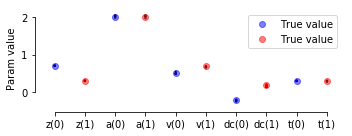

In [6]:
# parameter recovery plots:
params_recovered = params.loc[:, ['z(0)', 'z(1)', 'a(0)', 'a(1)', 'v(0)', 'v(1)', 'dc(0)', 'dc(1)', 't(0)', 't(1)']]
x = np.arange(5) * 2
y0 = np.array([params0['z'], params0['a'], params0['v'], params0['dc'], params0['t']])
y1 = np.array([params1['z'], params1['a'], params1['v'], params1['dc'], params1['t']])
fig = plt.figure(figsize=(5,2))
ax = fig.add_subplot(111)
ax.scatter(x, y0, color='blue', alpha=0.5, label='True value')
ax.scatter(x+1, y1, color='red', alpha=0.5, label='True value')
sns.stripplot(data=params_recovered, jitter=False, size=2, edgecolor='black', linewidth=0.25, alpha=1, palette=['blue', 'red'], ax=ax)
sns.despine(offset=5, trim=True,)
plt.legend()
plt.ylabel('Param value')
plt.tight_layout()
fig.savefig(os.path.join('plots', 'model_recovery.png'))

plot subj 0


/Users/janwillem/anaconda2/envs/ddm/lib/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


plot subj 1
plot subj 2
plot subj 3
plot subj 0
plot subj 1
plot subj 2
plot subj 3


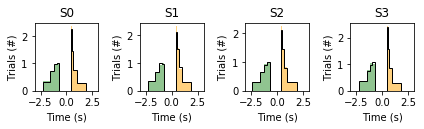

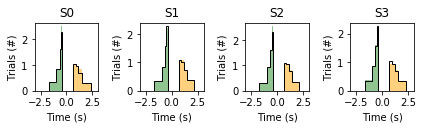

In [7]:
# model fits:
for condition in np.unique(df['condition']):
    fig = model_fit(params, df, condition=condition, quantiles=quantiles)
    fig.savefig(os.path.join('plots', 'model_fit_{}.png'.format(condition)))

plot subj 0


/Users/janwillem/anaconda2/envs/ddm/lib/python2.7/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


plot subj 1
plot subj 2
plot subj 3
plot subj 0
plot subj 1
plot subj 2
plot subj 3
plot subj 0
plot subj 1
plot subj 2
plot subj 3
plot subj 0
plot subj 1
plot subj 2
plot subj 3


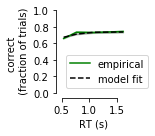

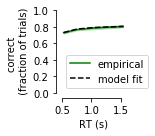

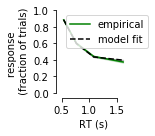

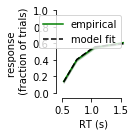

In [8]:
# conditional accuracy and response functions:
for measure in ['correct', 'response']:
    for condition in np.unique(df['condition']):
        fig = conditional_rt_plots(params, df, measure=measure, condition=condition, quantiles=quantiles)
        fig.savefig(os.path.join('plots', 'conditional_{}_{}.png'.format(measure, condition)))